# Import libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
from collections import Counter
pd.set_option('display.max_columns', 50)

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import and read data

In [5]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
ss = pd.read_csv('sampleSubmission.csv')

In [3]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [4]:
print("Training set shape: ", df_train.shape)
print("Test set shape: ", df_test.shape)

Training set shape:  (4250, 20)
Test set shape:  (750, 20)


# Exploratory Data Analysis (EDA)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             750 non-null    int64  
 1   state                          750 non-null    object 
 2   account_length                 750 non-null    int64  
 3   area_code                      750 non-null    object 
 4   international_plan             750 non-null    object 
 5   voice_mail_plan                750 non-null    object 
 6   number_vmail_messages          750 non-null    int64  
 7   total_day_minutes              750 non-null    float64
 8   total_day_calls                750 non-null    int64  
 9   total_day_charge               750 non-null    float64
 10  total_eve_minutes              750 non-null    float64
 11  total_eve_calls                750 non-null    int64  
 12  total_eve_charge               750 non-null    flo

In [7]:
id_test = df_test['id']
df_test.drop('id', axis=1, inplace=True)

In [8]:
# Check for constant variables
for col in df_train.copy():
    rate = df_train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.98:
        print(col)
print('df_train - Check!')

for col in df_test.copy():
    rate = df_test[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.98:
        print(col)
print('df_test - Check!')

df_train - Check!
df_test - Check!


### Target variable

In [9]:
df_train['churn'] = df_train['churn'].map({'no': 0, 'yes': 1})

In [10]:
df_train['churn'].value_counts(normalize=True)

0    0.859294
1    0.140706
Name: churn, dtype: float64

Classe está desbalanceada. Temos mais clientes que não mudaram de provedor!

### Categorical variables

In [11]:
cat_vars = ['state', 'area_code', 'international_plan', 'voice_mail_plan']

In [12]:
# Summary statistics
df_train.describe(include=['object'])

,state,area_code,international_plan,voice_mail_plan
count,4250,4250,4250,4250
unique,51,3,2,2
top,WV,area_code_415,no,no
freq,139,2108,3854,3138


In [13]:
df_test.describe(include=['object'])

,state,area_code,international_plan,voice_mail_plan
count,750,750,750,750
unique,51,3,2,2
top,AL,area_code_415,no,no
freq,23,387,673,539


#### Univariate Analysis

In [14]:
# function for display the percentage
def with_per(total, axis):
    for p in axis.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center')

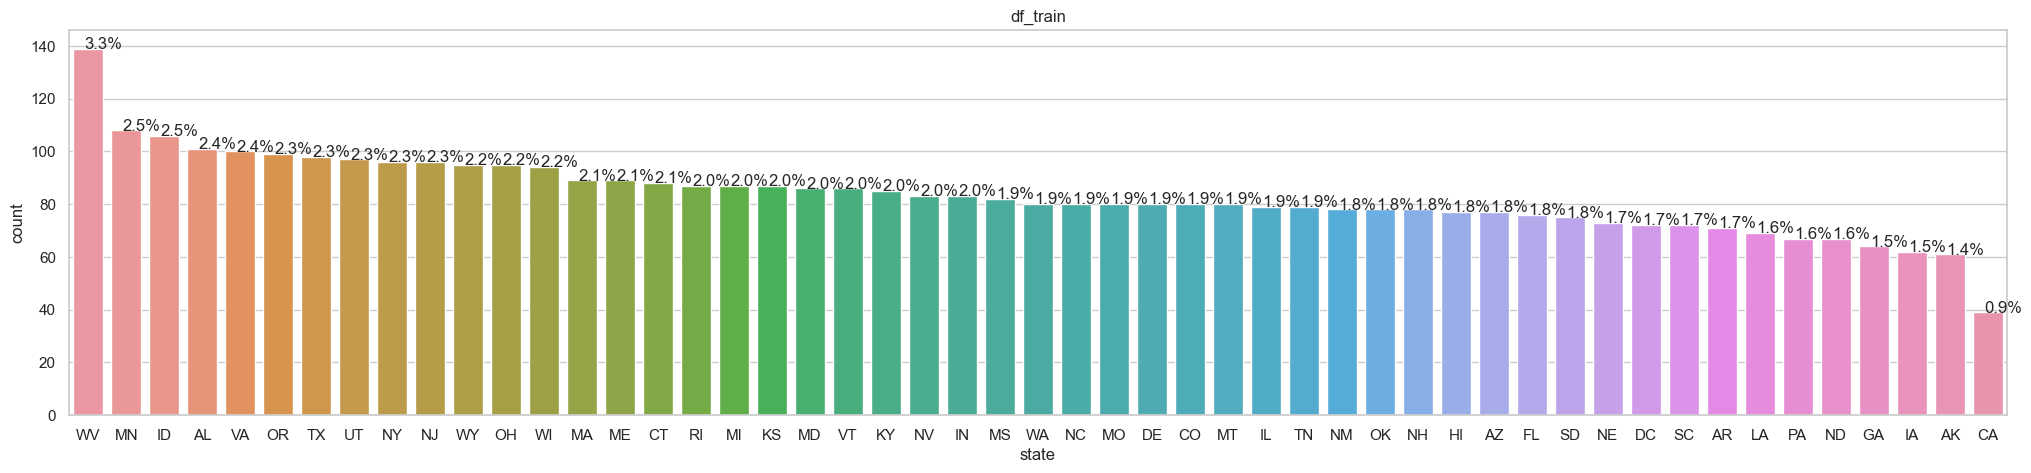

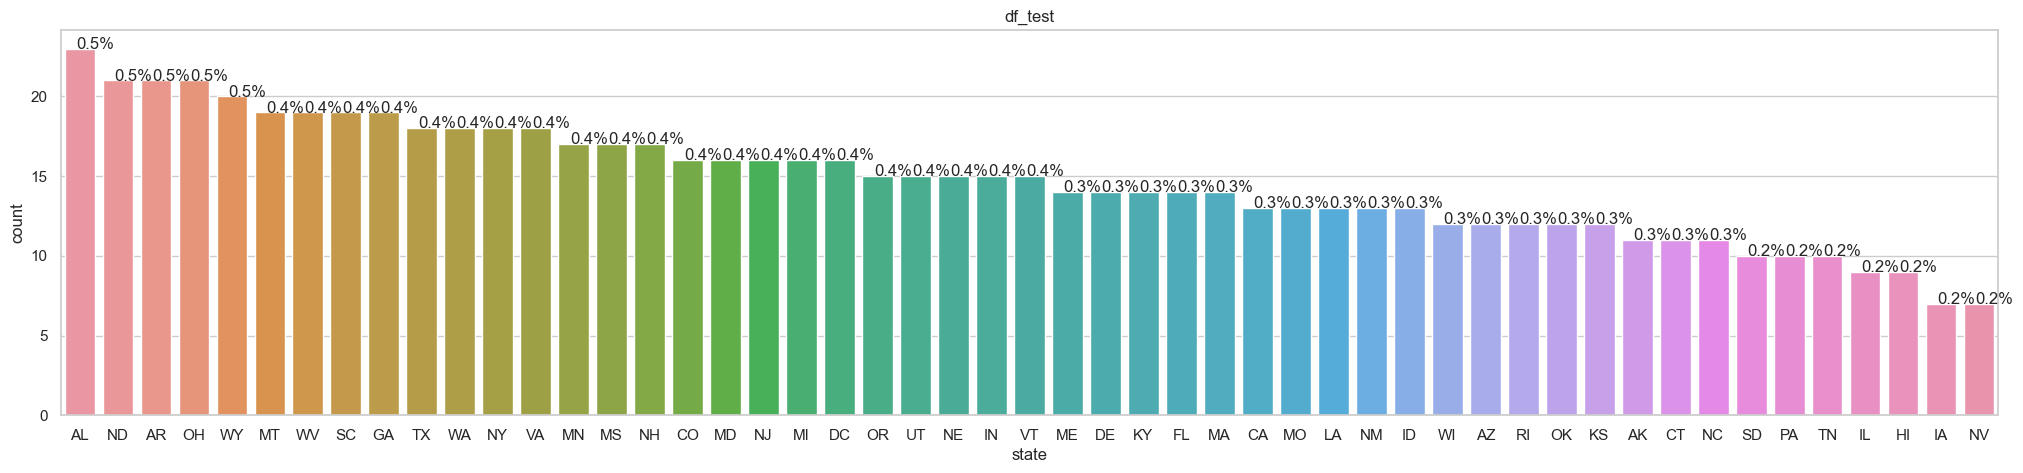

In [15]:
# Plot (Value Counts)
total = len(df_train)
sns.set(style = 'whitegrid')
plt.figure(figsize=(25,5))
ax = sns.countplot(x = 'state' , data = df_train, order = df_train['state'].value_counts().index)
ax.set_title('df_train')
with_per(total, ax)
plt.show()

total = len(df_train)
sns.set(style = 'whitegrid')
plt.figure(figsize=(25,5))
ax = sns.countplot(x = 'state' , data = df_test, order = df_test['state'].value_counts().index)
ax.set_title('df_test')
with_per(total, ax)
plt.show()

As distribuições da variável "state" estão muito diferentes entre os datasets. O modelo terá dificuldade de generalizar. Decidi remover.

In [16]:
df_train.drop('state', axis=1, inplace=True)
df_test.drop('state', axis=1, inplace=True)

In [17]:
print('=====df_train=====')
print(df_train['area_code'].value_counts(normalize=True))
print()
print('=====df_test======')
print(df_test['area_code'].value_counts(normalize=True))

=====df_train=====
area_code_415    0.496000
area_code_408    0.255529
area_code_510    0.248471
Name: area_code, dtype: float64

=====df_test======
area_code_415    0.516000
area_code_510    0.253333
area_code_408    0.230667
Name: area_code, dtype: float64


In [18]:
print('=====df_train=====')
print(df_train['international_plan'].value_counts(normalize=True))
print()
print('=====df_test======')
print(df_test['international_plan'].value_counts(normalize=True))

=====df_train=====
no     0.906824
yes    0.093176
Name: international_plan, dtype: float64

=====df_test======
no     0.897333
yes    0.102667
Name: international_plan, dtype: float64


In [19]:
print('=====df_train=====')
print(df_train['voice_mail_plan'].value_counts(normalize=True))
print()
print('=====df_test======')
print(df_test['voice_mail_plan'].value_counts(normalize=True))

=====df_train=====
no     0.738353
yes    0.261647
Name: voice_mail_plan, dtype: float64

=====df_test======
no     0.718667
yes    0.281333
Name: voice_mail_plan, dtype: float64


#### Bivariate Analysis

<AxesSubplot: xlabel='area_code', ylabel='count'>

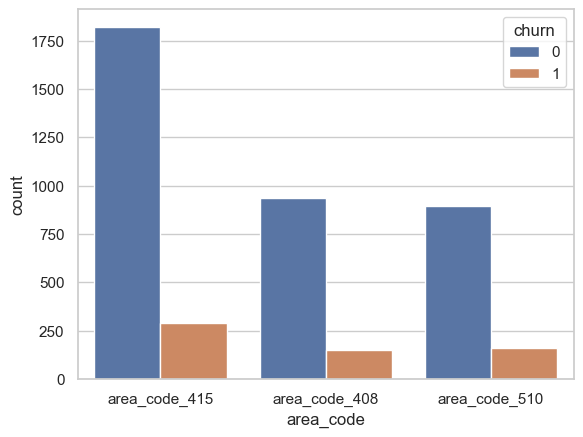

In [20]:
# Plot
sns.countplot(x = 'area_code' , hue = 'churn',data = df_train)

<AxesSubplot: xlabel='international_plan', ylabel='count'>

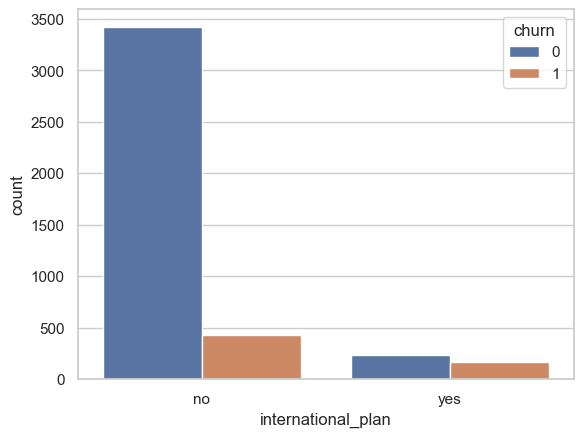

In [21]:
# Plot
sns.countplot(x = 'international_plan' , hue = 'churn',data = df_train)

Clientes com plano internacional apresentam maior problabilidade de mudança.

<AxesSubplot: xlabel='voice_mail_plan', ylabel='count'>

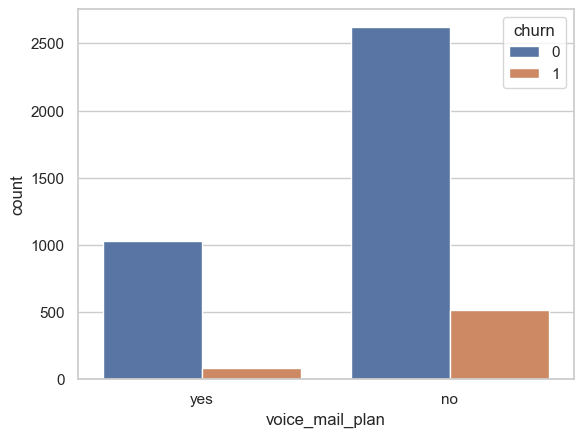

In [22]:
# Plot
sns.countplot(x = 'voice_mail_plan' , hue = 'churn',data = df_train)

### Numerical variables

In [23]:
num_vars = [col for col in df_train.columns if (df_train[col].dtypes != 'O') & (col != 'churn')]
len(num_vars)

15

In [24]:
# Summary statistics
df_train.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059,0.140706
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434,0.347759
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000,0.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


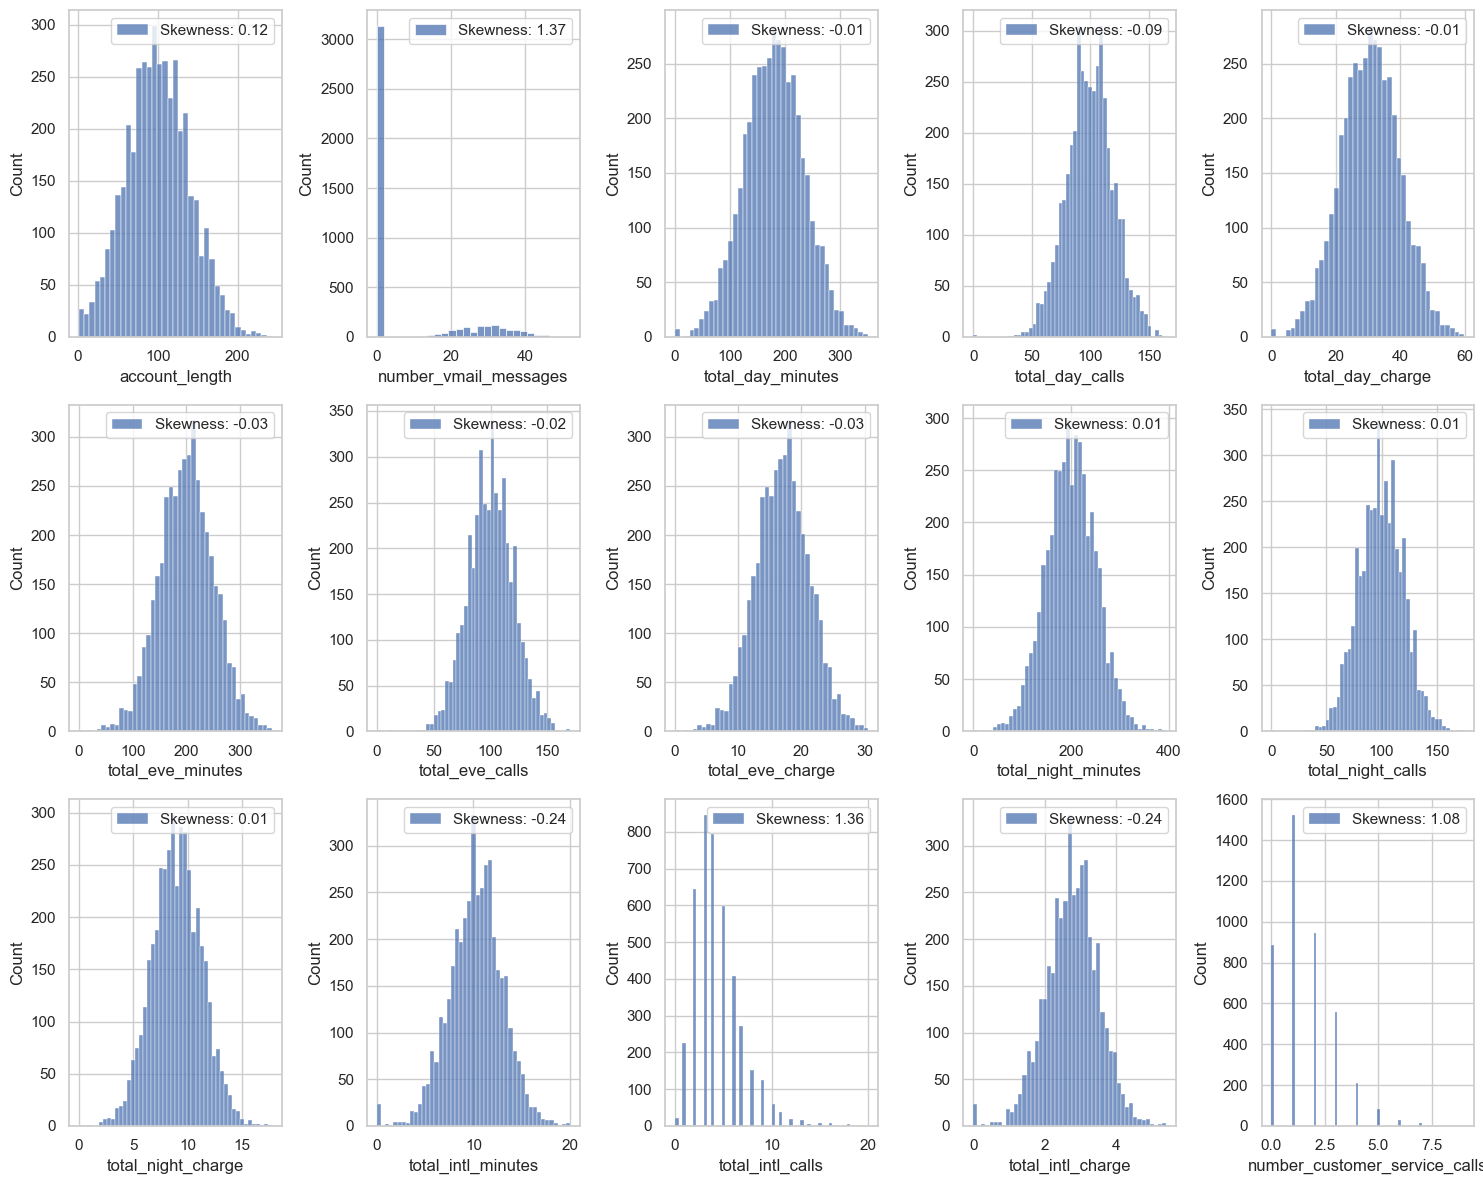

In [25]:
# Plot
plt.figure(figsize=(15, 12))
for n, col in enumerate(num_vars):
    ax = plt.subplot(3, 5, n + 1)
    sns.histplot(df_train[col], ax=ax, label = 'Skewness: %.2f'%(df_train[col].skew()))
    plt.legend(loc = 'best')
plt.tight_layout()

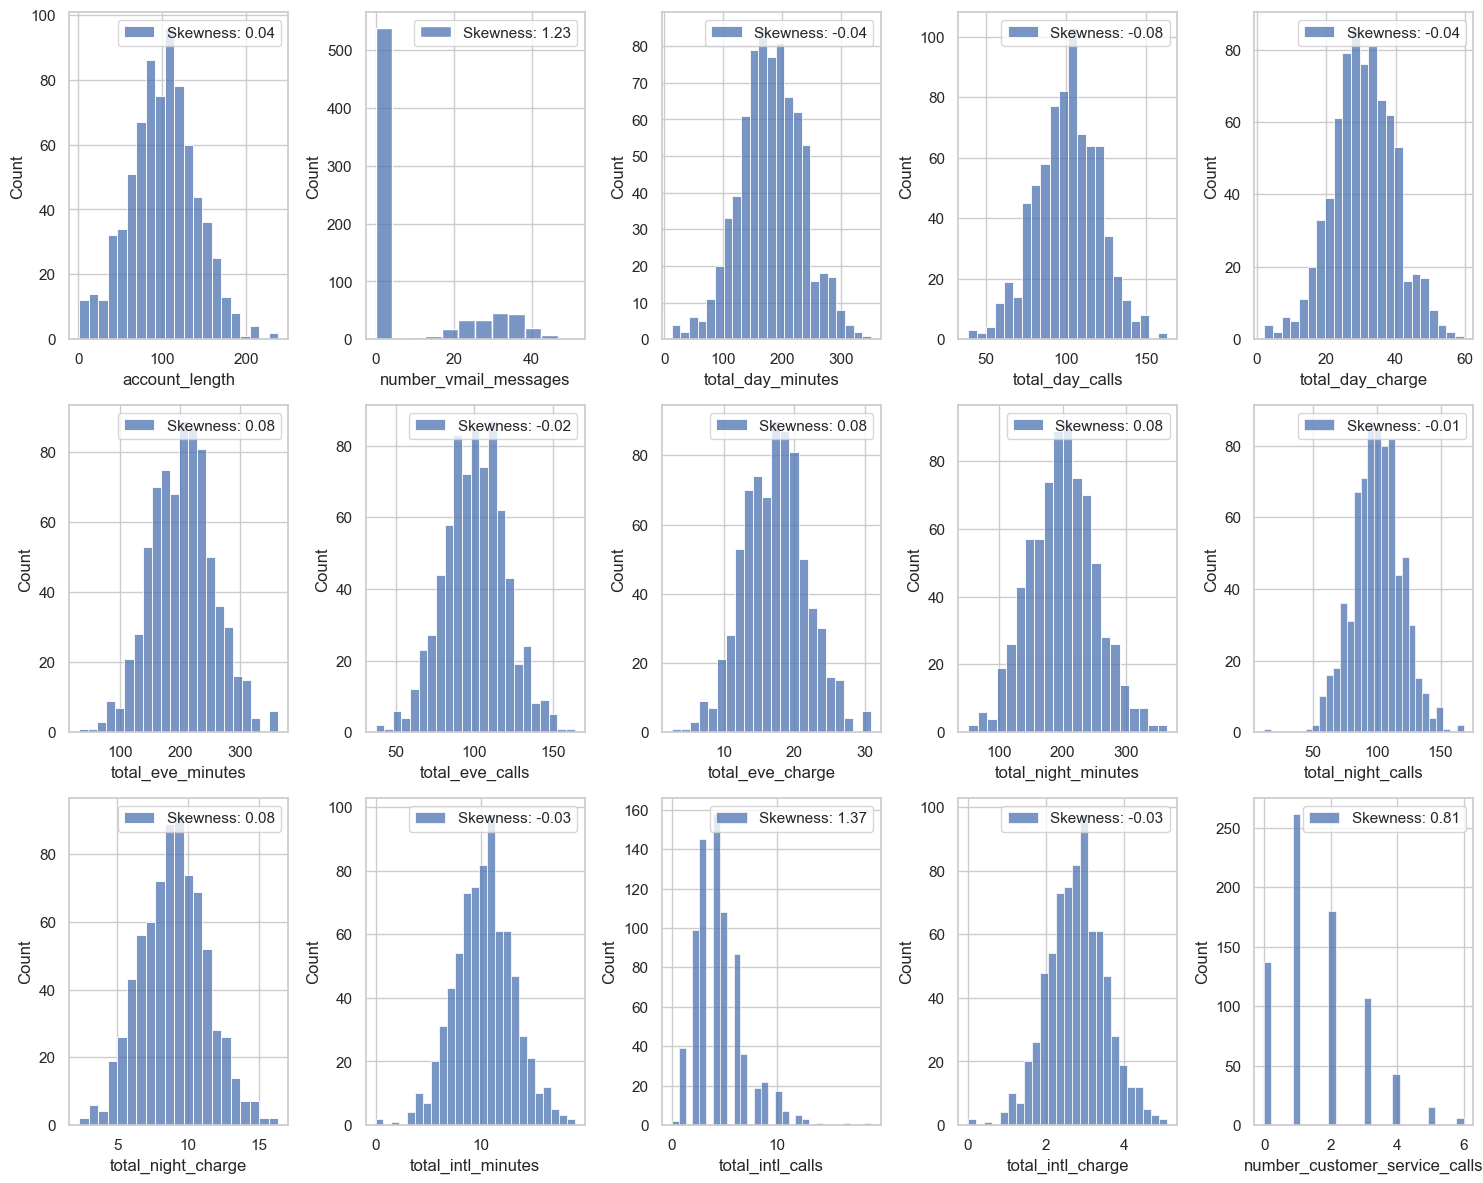

In [26]:
# Plot
plt.figure(figsize=(15, 12))
for n, col in enumerate(num_vars):
    ax = plt.subplot(3, 5, n + 1)
    sns.histplot(df_test[col], ax=ax, label = 'Skewness: %.2f'%(df_test[col].skew()))
    plt.legend(loc = 'best')
plt.tight_layout()

In [27]:
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(df_train, 2, num_vars)
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 20 indices:  [2725, 96, 2691, 12, 1138, 1183, 2318, 4157, 1661, 1986, 2482, 3213, 739, 2756, 3713, 4001, 3877, 2470, 2807, 4209]


In [28]:
# Outliers in numerical variables
df_train[num_vars].loc[outliers_to_drop, :]

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
2725,221,24,180.5,85,30.69,224.1,92,19.05,205.7,103,9.26,2.4,3,0.65,0
96,36,42,196.8,89,33.46,254.9,122,21.67,138.3,126,6.22,20.0,6,5.40,0
2691,36,43,29.9,123,5.08,129.1,117,10.97,325.9,105,14.67,8.6,6,2.32,2
12,161,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4
1138,98,0,0.0,0,0.00,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4
1183,101,0,0.0,0,0.00,192.1,119,16.33,168.8,95,7.60,7.2,4,1.94,1
2318,127,27,2.6,113,0.44,254.0,102,21.59,242.7,156,10.92,9.2,5,2.48,3
4157,63,0,6.6,107,1.12,359.3,142,30.54,252.5,131,11.36,5.6,3,1.51,0
1661,38,0,149.0,92,25.33,49.2,78,4.18,163.3,93,7.35,13.9,11,3.75,0
1986,139,0,181.6,119,30.87,335.7,118,28.53,149.8,64,6.74,8.3,6,2.24,4


In [29]:
# Drop outliers and reset index
print("Before: {} rows".format(len(df_train)))
df_train = df_train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(df_train)))

Before: 4250 rows
After: 4230 rows


# Data preprocessing

### Feature engineering

I will construct 3 new features:

* Total Minutes
* Total Calls
* Total Charge

In [30]:
# Train
df_train['total_minutes'] = df_train['total_day_minutes'] + df_train['total_eve_minutes'] + df_train['total_night_minutes'] + df_train['total_intl_minutes'] 
df_train['total_calls'] = df_train['total_day_calls'] + df_train['total_eve_calls'] + df_train['total_night_calls'] + df_train['total_intl_calls']
df_train['total_charge'] = df_train['total_day_charge'] + df_train['total_eve_charge'] + df_train['total_night_charge'] + df_train['total_intl_charge']

# Test
df_test['total_minutes'] = df_test['total_day_minutes'] + df_test['total_eve_minutes'] + df_test['total_night_minutes'] + df_test['total_intl_minutes'] 
df_test['total_calls'] = df_test['total_day_calls'] + df_test['total_eve_calls'] + df_test['total_night_calls'] + df_test['total_intl_calls']
df_test['total_charge'] = df_test['total_day_charge'] + df_test['total_eve_charge'] + df_test['total_night_charge'] + df_test['total_intl_charge']

### Feature encoding

In [31]:
# Train
df_train['area_code'] = df_train['area_code'].apply(lambda x: int(x.split("_")[2]))
df_train['international_plan'] = df_train['international_plan'].map({'no':False, 'yes':True})
df_train['voice_mail_plan'] = df_train['voice_mail_plan'].map({'no':False, 'yes':True})

# Test
df_test['area_code'] = df_test['area_code'].apply(lambda x: int(x.split("_")[2]))
df_test['international_plan'] = df_test['international_plan'].map({'no':False, 'yes':True})
df_test['voice_mail_plan'] = df_test['voice_mail_plan'].map({'no':False, 'yes':True})

### Correlation

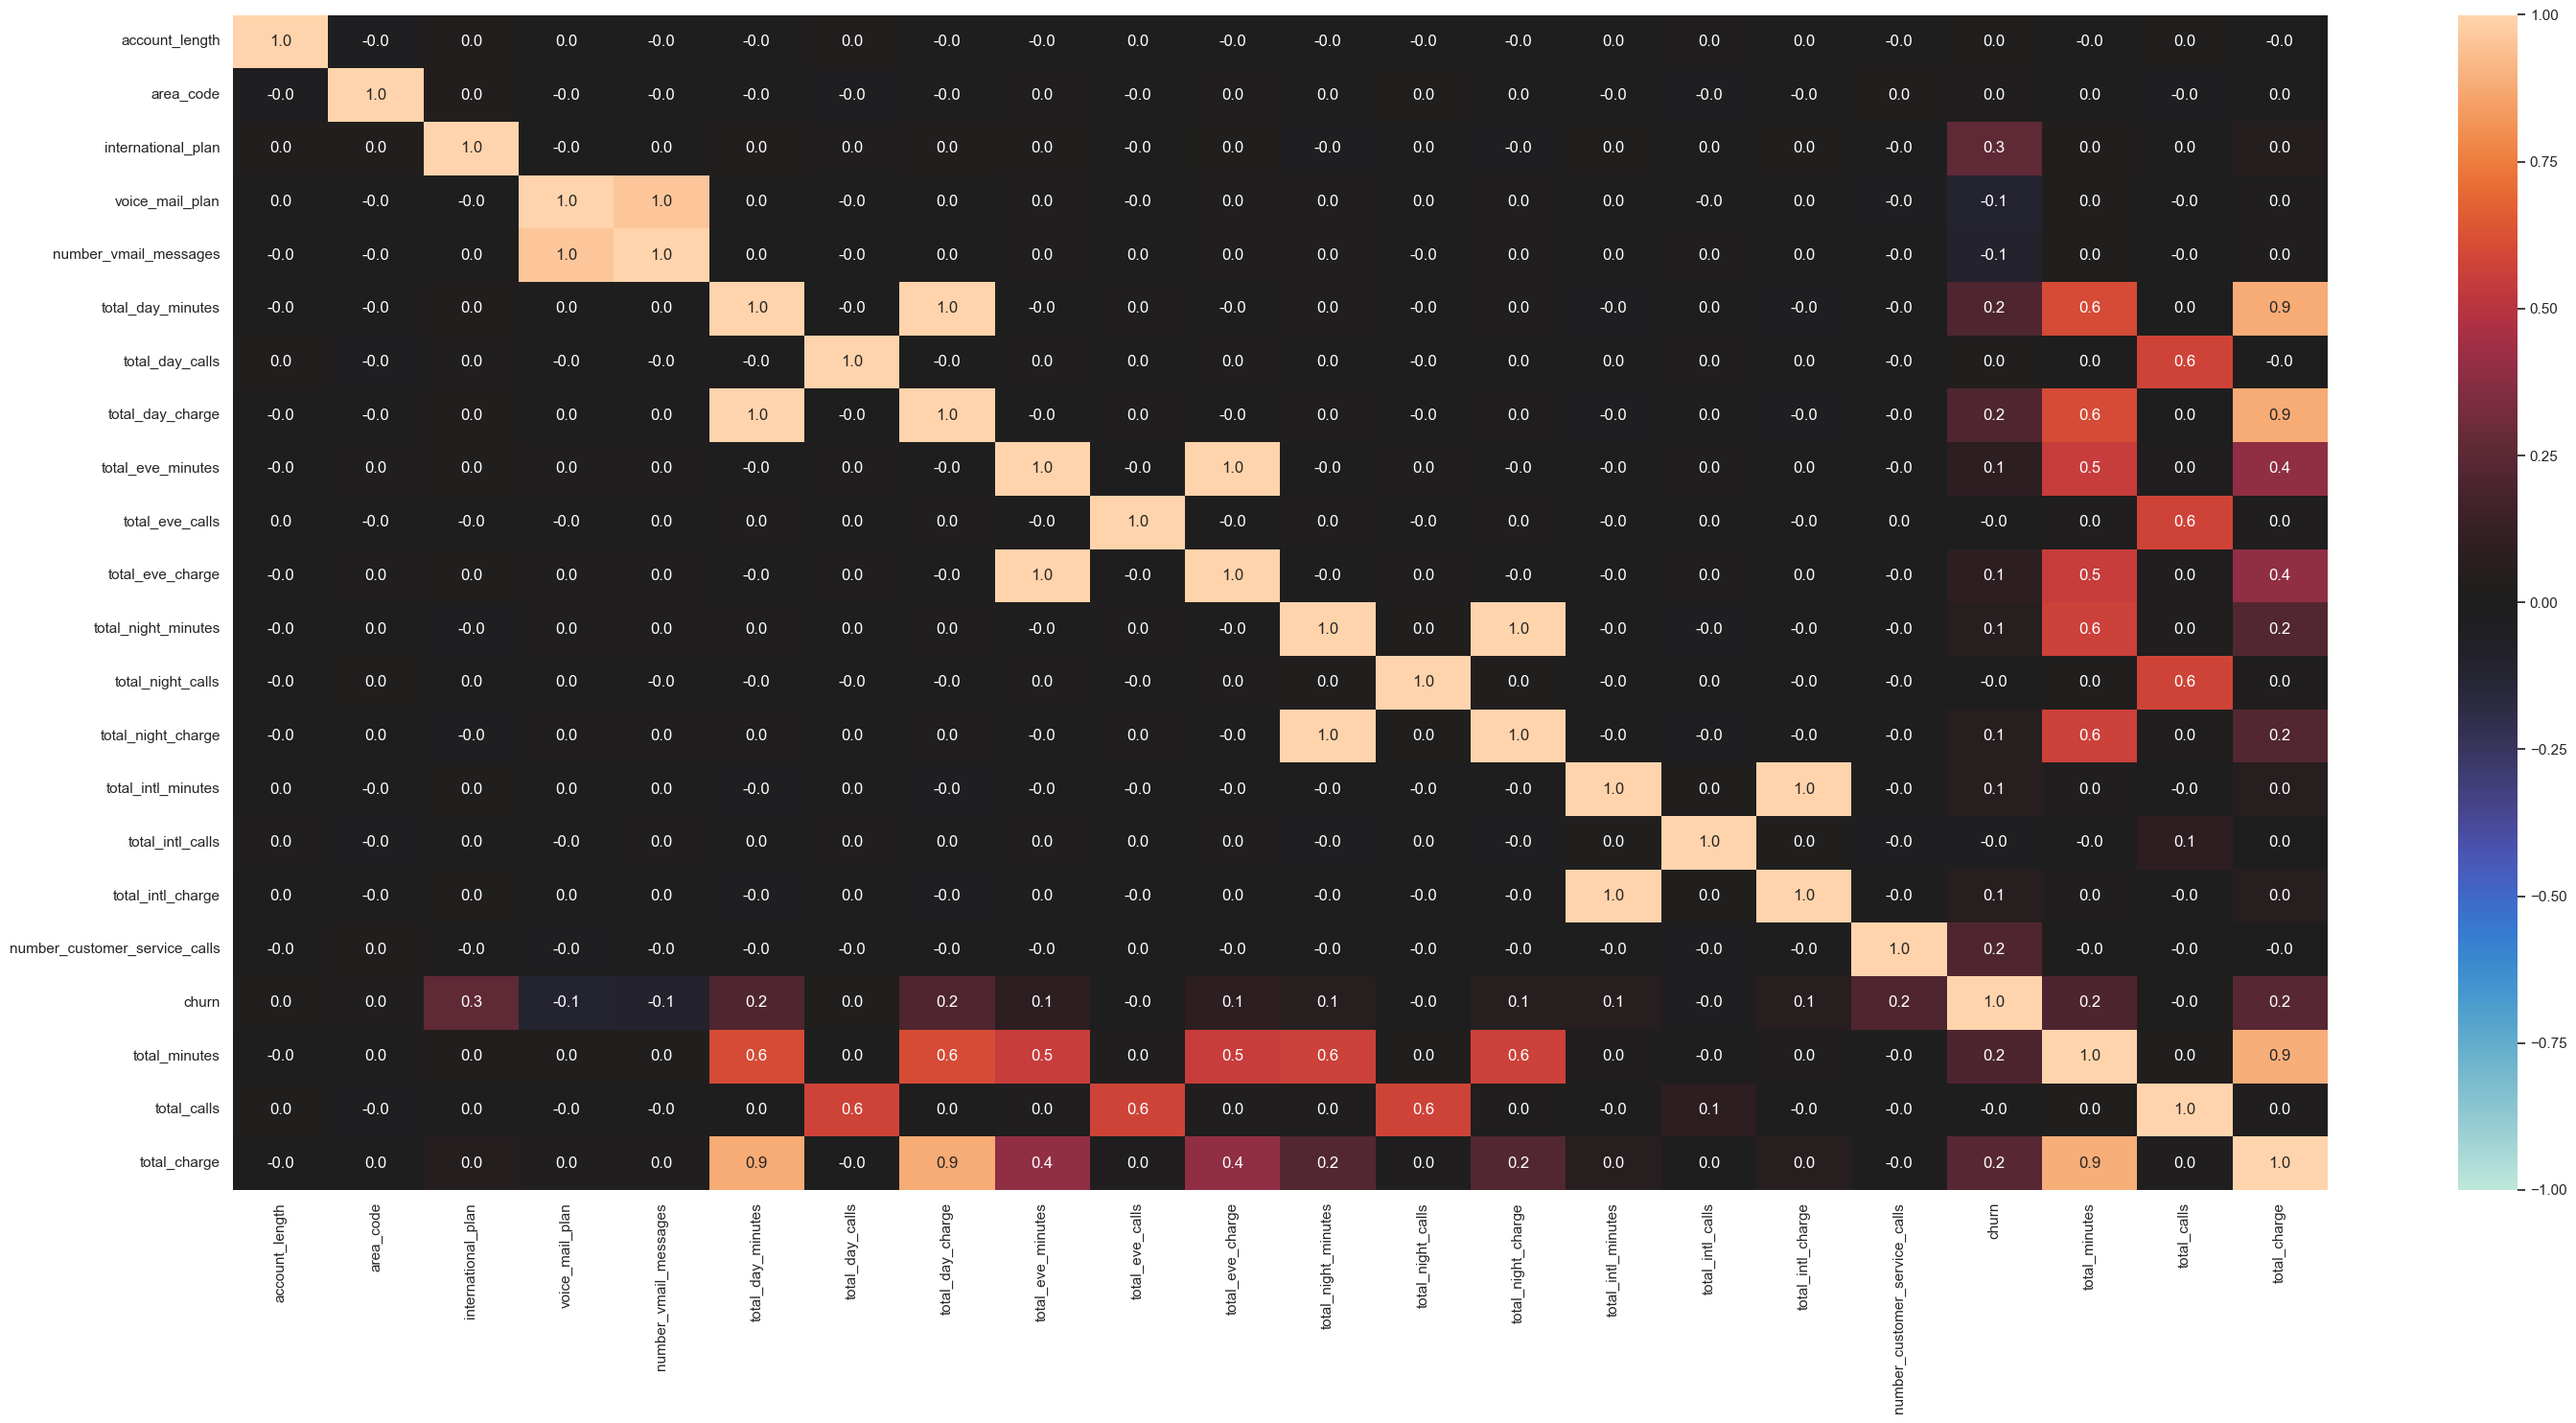

In [32]:
# Plot
plt.figure(figsize=(30, 15))
sns.heatmap(df_train.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, cmap='icefire')
plt.tight_layout()

In [33]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [34]:
corr_features = correlation(df_train, 0.95)
len(set(corr_features))
print('correlated features: ', len(set(corr_features)))

correlated features:  5


In [35]:
print('correlated features are: ', corr_features)

correlated features are:  {'total_day_charge', 'total_eve_charge', 'total_night_charge', 'number_vmail_messages', 'total_intl_charge'}


In [36]:
df_train.drop(corr_features, axis=1, inplace=True)
df_test.drop(corr_features, axis=1, inplace=True)

#### Int Downcasting Value Range

* int8  can store integers from -128 to 127
* int16 can store integers from -32768 to 32767
* int64 can store integers from -9223372036854775808 to 9223372036854775807.

In [37]:
# OPTIMIZE MEMORY
def reduce_memory(df,col):
    mx = df[col].max()
    mn = df[col].min()
    if (mn > -128) & (mx < 127):
            df[col] = df[col].astype('uint8')
    elif (mn > -32768) & (mx < 32767):
        df[col] = df[col].astype('uint16')
    else:
        df[col] = df[col].astype('uint32')
        
int_list = ['account_length', 'area_code', 'total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls', 
            'number_customer_service_calls', 'total_calls']
        
for col in int_list:
    reduce_memory(df_train, col)
    
for col in int_list:
    reduce_memory(df_test, col)
    
df_train['churn'] = df_train['churn'].astype('uint8')

# Modelling

### Split training data

In [38]:
X = df_train.drop("churn", axis=1)
y = df_train["churn"]

### Cross Validation with DecisionTree, RandomForest, LightGBM and XGBoost

In [39]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold = 0
accs = []

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = DecisionTreeClassifier()
    clf.fit(X_tr, y_tr)
        
    pred = clf.predict(X_val)
    acc_score = accuracy_score(y_val, pred)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}"
    )
    fold += 1
    accs.append(acc_score)
oof_acc = np.mean(accs)
print('=======================')
print(f'Our out of fold ACC score is {oof_acc:0.4f}')

======= Fold 0 ========
Our accuracy on the validation set is 0.9563
======= Fold 1 ========
Our accuracy on the validation set is 0.9492
======= Fold 2 ========
Our accuracy on the validation set is 0.9515
======= Fold 3 ========
Our accuracy on the validation set is 0.9598
======= Fold 4 ========
Our accuracy on the validation set is 0.9574
Our out of fold ACC score is 0.9548


In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold = 0
accs = []

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = RandomForestClassifier(n_estimators=300)
    clf.fit(X_tr, y_tr)
        
    pred = clf.predict(X_val)
    acc_score = accuracy_score(y_val, pred)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}"
    )
    fold += 1
    accs.append(acc_score)
oof_acc = np.mean(accs)
print('=======================')
print(f'Our out of fold ACC score is {oof_acc:0.4f}')

======= Fold 0 ========
Our accuracy on the validation set is 0.9775
======= Fold 1 ========
Our accuracy on the validation set is 0.9835
======= Fold 2 ========
Our accuracy on the validation set is 0.9811
======= Fold 3 ========
Our accuracy on the validation set is 0.9775
======= Fold 4 ========
Our accuracy on the validation set is 0.9740
Our out of fold ACC score is 0.9787


In [41]:
skf = StratifiedKFold(n_splits=25, shuffle=True)
fold = 0
accs = []

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = LGBMClassifier(n_estimators=300)
    clf.fit(X_tr, y_tr, eval_metric='accuracy', eval_set=[(X_val, y_val)], verbose=False)
        
    pred = clf.predict(X_val)
    acc_score = accuracy_score(y_val, pred)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}"
    )
    fold += 1
    accs.append(acc_score)
oof_acc = np.mean(accs)
print('=======================')
print(f'Our out of fold ACC score is {oof_acc:0.4f}')

======= Fold 0 ========
Our accuracy on the validation set is 0.9824
======= Fold 1 ========
Our accuracy on the validation set is 0.9824
======= Fold 2 ========
Our accuracy on the validation set is 0.9647
======= Fold 3 ========
Our accuracy on the validation set is 0.9882
======= Fold 4 ========
Our accuracy on the validation set is 0.9765
======= Fold 5 ========
Our accuracy on the validation set is 0.9822
======= Fold 6 ========
Our accuracy on the validation set is 0.9941
======= Fold 7 ========
Our accuracy on the validation set is 0.9763
======= Fold 8 ========
Our accuracy on the validation set is 0.9822
======= Fold 9 ========
Our accuracy on the validation set is 0.9704
======= Fold 10 ========
Our accuracy on the validation set is 0.9822
======= Fold 11 ========
Our accuracy on the validation set is 0.9882
======= Fold 12 ========
Our accuracy on the validation set is 0.9645
======= Fold 13 ========
Our accuracy on the validation set is 0.9645
======= Fold 14 ========
Our a

In [42]:
skf = StratifiedKFold(n_splits=25, shuffle=True)
fold = 0
accs = []

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = XGBClassifier(n_estimators=300)
    clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
    pred = clf.predict(X_val)
    acc_score = accuracy_score(y_val, pred)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}"
    )
    fold += 1
    accs.append(acc_score)
oof_acc = np.mean(accs)
print('=======================')
print(f'Our out of fold ACC score is {oof_acc:0.4f}')

======= Fold 0 ========
Our accuracy on the validation set is 0.9765
======= Fold 1 ========
Our accuracy on the validation set is 0.9765
======= Fold 2 ========
Our accuracy on the validation set is 0.9824
======= Fold 3 ========
Our accuracy on the validation set is 0.9824
======= Fold 4 ========
Our accuracy on the validation set is 0.9882
======= Fold 5 ========
Our accuracy on the validation set is 0.9645
======= Fold 6 ========
Our accuracy on the validation set is 1.0000
======= Fold 7 ========
Our accuracy on the validation set is 0.9882
======= Fold 8 ========
Our accuracy on the validation set is 0.9882
======= Fold 9 ========
Our accuracy on the validation set is 0.9704
======= Fold 10 ========
Our accuracy on the validation set is 0.9882
======= Fold 11 ========
Our accuracy on the validation set is 0.9763
======= Fold 12 ========
Our accuracy on the validation set is 0.9882
======= Fold 13 ========
Our accuracy on the validation set is 0.9822
======= Fold 14 ========
Our a

#### Feature Importance

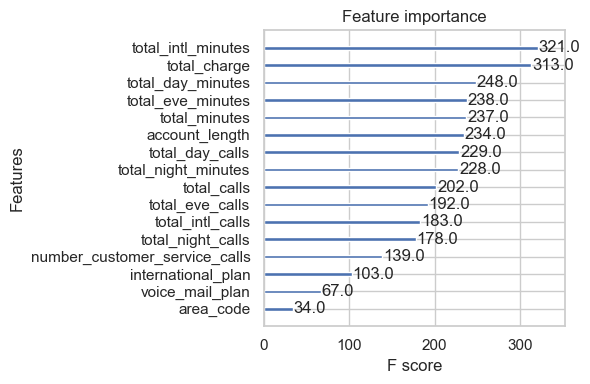

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
xgb.plot_importance(clf, ax=ax)
fig.tight_layout()

### Hyperparameter tuning for best model

In [44]:
from sklearn.model_selection import GridSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True)

# create a dictionary containing the hyperparameters
# to tune and the range of values to try
PARAMETERS = {'gamma': [0,0.1,0.4,0.8,1.6,3.2,6.4,12.8],
              'learning_rate': [0.01, 0.04, 0.1, 0.15, 0.2, 0.25],
              'max_depth': [8,9,10,11,12,13,-1],
              'n_estimators': [1000, 2000, 3000],
              'colsample_bytree' : [0.01,0.1,0.5,1,1.5,2]}

# create a validation set which will be used for early stopping
eval_set = [(X_val, y_val)]

# initialise an XGBoost classifier, set the number of estimators,
# evaluation metric & early stopping rounds
estimator = XGBClassifier(n_jobs=-1, early_stopping_rounds=100)

# initialise GridSearchCV model by passing the XGB classifier we
# initialised in the last step along with the dictionary of parameters
# and values to try. We also set the number of folds to validate over
# along with the scoring metic to use
model = GridSearchCV(estimator=estimator,
                    param_grid=PARAMETERS,
                    scoring="accuracy",
                    n_jobs=-1,
                    cv= skf.split(X,y),
                    verbose=1)

# fit model
model.fit(X, y, eval_set=eval_set, verbose=False)

# print out the best hyperparameters
print(model.best_params_)

Fitting 5 folds for each of 6048 candidates, totalling 30240 fits
{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 2000}


In [46]:
skf = StratifiedKFold(n_splits=20, shuffle=True)
fold = 0
accs = []

for train_idx, val_idx in skf.split(X, y):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = xgb.XGBClassifier(n_estimators=2000, gamma=0.1, learning_rate=0.01, max_depth=8, colsample_bytree=0.5)
    clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=100)
        
    pred = clf.predict(X_val)
    acc_score = accuracy_score(y_val, pred)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f}"
    )
    fold += 1
    accs.append(acc_score)
oof_acc = np.mean(accs)
print('=======================')
print(f'Our out of fold ACC score is {oof_acc:0.4f}')

======= Fold 0 ========
Our accuracy on the validation set is 0.9811
======= Fold 1 ========
Our accuracy on the validation set is 0.9764
======= Fold 2 ========
Our accuracy on the validation set is 0.9906
======= Fold 3 ========
Our accuracy on the validation set is 0.9764
======= Fold 4 ========
Our accuracy on the validation set is 0.9623
======= Fold 5 ========
Our accuracy on the validation set is 0.9858
======= Fold 6 ========
Our accuracy on the validation set is 0.9717
======= Fold 7 ========
Our accuracy on the validation set is 0.9717
======= Fold 8 ========
Our accuracy on the validation set is 0.9811
======= Fold 9 ========
Our accuracy on the validation set is 0.9858
======= Fold 10 ========
Our accuracy on the validation set is 0.9905
======= Fold 11 ========
Our accuracy on the validation set is 0.9905
======= Fold 12 ========
Our accuracy on the validation set is 0.9763
======= Fold 13 ========
Our accuracy on the validation set is 0.9810
======= Fold 14 ========
Our a

# Predict and Submission

In [47]:
y_pred = clf.predict(df_test)
ss['churn'] = y_pred
ss['churn'] = ss['churn'].map({0:'no', 1:'yes'})
ss.head()

,id,churn
0,1,no
1,2,no
2,3,no
3,4,no
4,5,no


In [48]:
ss.to_csv('xgb.csv', index=False)

#### Score on Kaggle: 

* Public Score: 0.99111
* Private Score: 0.97333